# Electric Power Consumption Prediction Project
Name : Diandra Regita Abigail Damanik

Email : diandraregita14@gmail.com

## 1. Setup and Data Acquisition

### 1.1 Installing Required Libraries

In [1]:
!pip install kaggle

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import zipfile

from google.colab import drive
from keras.layers import Dense, LSTM

In [4]:
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


### 1.2 Kaggle Dataset Download

In [5]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

 52% 10.0M/19.4M [00:00<00:00, 105MB/s]
100% 19.4M/19.4M [00:00<00:00, 144MB/s]


In [6]:
# Unzip the file to a specific destination
with zipfile.ZipFile('electric-power-consumption-data-set.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

## 2. Data Preprocessing

### 2.1 Loading and Cleaning the Data

In [ ]:
dtype_dict = {
    'Date': str,
    'Time': str,
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
}

file_path = 'household_power_consumption.txt'

# Read the file into a DataFrame
df = pd.read_csv(file_path, delimiter=';', dtype=dtype_dict, parse_dates={'datetime': ['Date', 'Time']}, dayfirst=True, na_values='?')
df.replace('?', pd.NaT, inplace=True)
df.set_index('datetime', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

The data that is used for this project is only the last 30000 rows

In [20]:
df = df.tail(30000)

## 3. Exploratory Data Analysis (EDA)

In [28]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### 3.1 Visualizing the Data

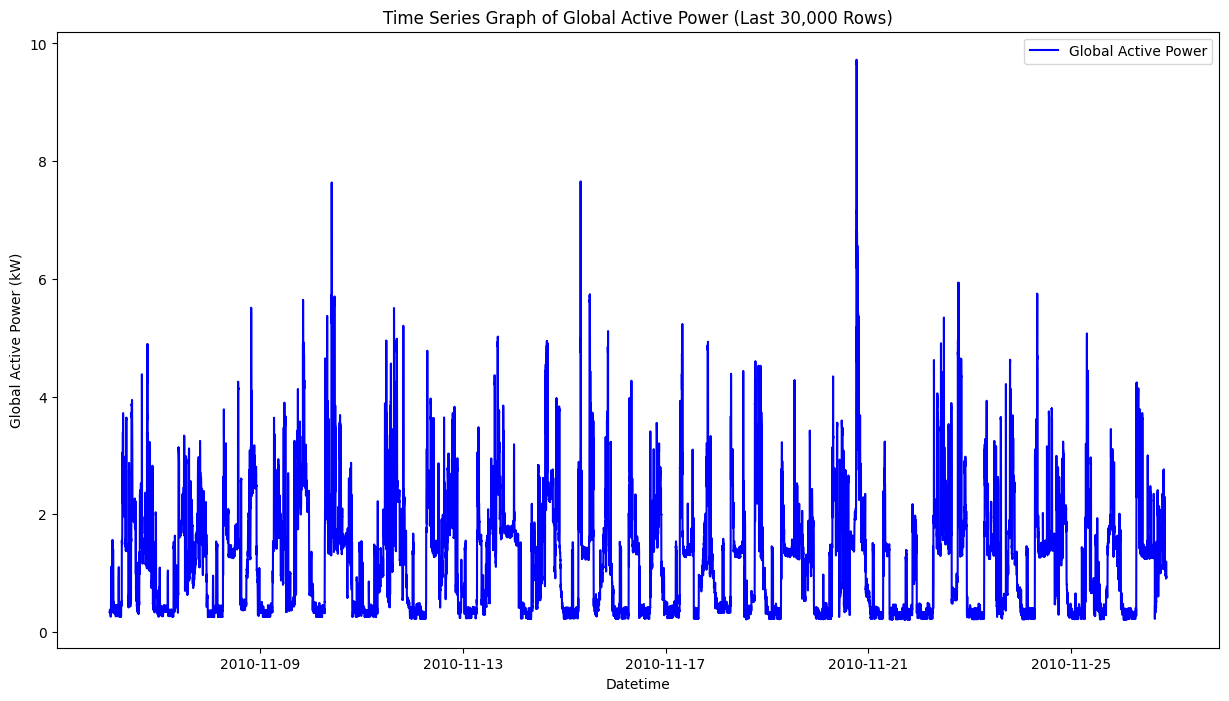

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='blue')
plt.title('Time Series Graph of Global Active Power (Last 30,000 Rows)')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## 4. Model Building

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, validation_split=0.2):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)

    # Split the dataset into training and validation sets
    total_size = len(series)
    train_size = int((1 - validation_split) * total_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    train_ds = train_ds.map(lambda w: (w[:-1], w[-1:]))
    val_ds = val_ds.map(lambda w: (w[:-1], w[-1:]))

    return train_ds.batch(batch_size).prefetch(1), val_ds.batch(batch_size).prefetch(1)

### 4.1 LSTM Model for Time Series Prediction

In [34]:
train_set, val_set = windowed_dataset(df['Global_active_power'].values,
                                      window_size=60, batch_size=100,
                                      shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

## 5. Model Training and Evaluation

In [33]:
def calculate_threshold(data_column):
    # Calculate 10% of the data scale
    data_scale = data_column.max() - data_column.min()
    return 0.1 * data_scale

threshold = calculate_threshold(df['Global_active_power'])

In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    min_delta=threshold,  # Minimum change to qualify as an improvement
    patience=3,
    restore_best_weights=True,
)

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[early_stopping])

Epoch 1/100
240/240 [==============================] - 54s 197ms/step - loss: 0.6417 - mae: 0.9945 - val_loss: 0.4396 - val_mae: 0.7483
Epoch 2/100
240/240 [==============================] - 46s 193ms/step - loss: 0.3838 - mae: 0.7017 - val_loss: 0.2526 - val_mae: 0.5781
Epoch 3/100
240/240 [==============================] - 46s 190ms/step - loss: 0.2540 - mae: 0.5769 - val_loss: 0.1892 - val_mae: 0.4893
Epoch 4/100
240/240 [==============================] - 46s 191ms/step - loss: 0.2060 - mae: 0.5093 - val_loss: 0.1604 - val_mae: 0.4383


### 5.1 Model Evaluation Metrics

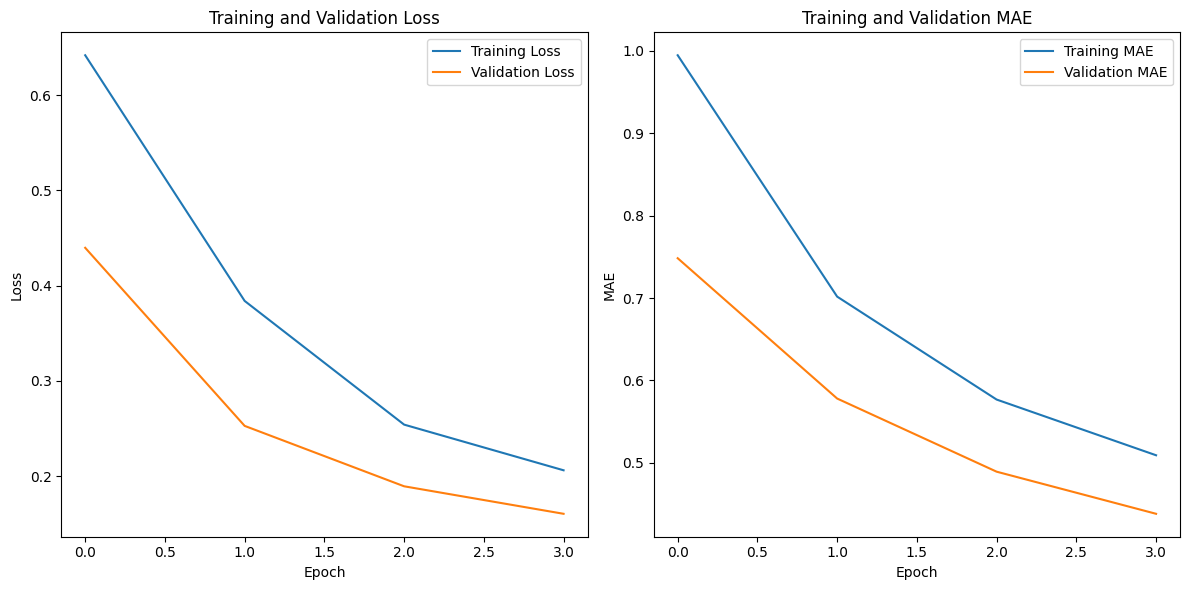

In [40]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Check if the final MAE is less than the threshold
final_mae = history.history['mae'][-1]

if final_mae < threshold:
    print(f"The final MAE ({final_mae:.2f}) is less than 10% of the data scale.")
else:
    print(f"The final MAE ({final_mae:.2f}) is greater than or equal to 10% of the data scale.")


The final MAE (0.51) is less than 10% of the data scale.
